In [10]:
%%capture
!pip install kagglehub numpy pandas scikit-learn imblearn xgboost lightgbm matplotlib seaborn


In [2]:
import numpy as np
import pandas as pd
import os

# Для классификации
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Для балансировки классов
#!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

# Модели
#!pip install xgboost lightgbm
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

# Для аномалий
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import IsolationForest

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mkashifn/nbaiot-dataset")

print("Path to dataset files:", path)


Path to dataset files: /home/krig/.cache/kagglehub/datasets/mkashifn/nbaiot-dataset/versions/1


In [4]:
import numpy as np
import pandas as pd
import os

DATA_DIR = "/home/krig/.cache/kagglehub/datasets/mkashifn/nbaiot-dataset/versions/1"  
csv_files = [
    i for i in os.listdir(DATA_DIR)
    if i.endswith(".csv") and i.split(".")[0].isdigit() and i.split(".")[0] == "1"
]

def get_label_and_device(filename: str) -> tuple[str, int]:
    parts = filename.split(".")
    label = parts[1] if parts[1] == "benign" else f"{parts[1]}_{parts[2]}"
    device = int(parts[0])
    return label, device

df_list = []
for file in csv_files:
    temp_df = pd.read_csv(os.path.join(DATA_DIR, file))
    label, device = get_label_and_device(file)
    temp_df['label'] = label
    temp_df['device_id'] = device
    df_list.append(temp_df)

df = pd.concat(df_list, ignore_index=True)
print("Размер объединённого датасета:", df.shape)


Размер объединённого датасета: (1018298, 117)


In [5]:
# Проверка пропусков
missing_count = df.isnull().sum()
print("Число пропусков в каждом признаке:\n", missing_count[missing_count > 0])


Число пропусков в каждом признаке:
 Series([], dtype: int64)


In [6]:
# Заполнение пропусков медианой
df.fillna(df.median(numeric_only=True), inplace=True)
print("\nПосле заполнения пропусков:\n", df.isnull().sum().max())



После заполнения пропусков:
 0


In [7]:
# Удаление дубликатов
initial_size = df.shape[0]
df.drop_duplicates(inplace=True)
print("Удалено дубликатов:", initial_size - df.shape[0])


Удалено дубликатов: 21759


# ------------------Binary XGBoost (Preparation)------------------

Adding binary lables, where benign is 0 and all malicious is 1


In [8]:
# Подготовка для бинарной классификации
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

df_binary = df.copy()
df_binary['binary_label'] = df_binary['label'].apply(lambda x: 0 if x.lower() == 'benign' else 1)
df_binary.drop(columns=['label'], inplace=True)

X_binary = df_binary.drop(columns=['binary_label'])
y_binary = df_binary['binary_label']

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    X_binary, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

smote = SMOTE(random_state=42)
X_train_b_bal, y_train_b_bal = smote.fit_resample(X_train_b, y_train_b)
print("После SMOTE:", np.bincount(y_train_b_bal))


После SMOTE: [764915 764915]


# Train XGBoost classifier (parallel execution)

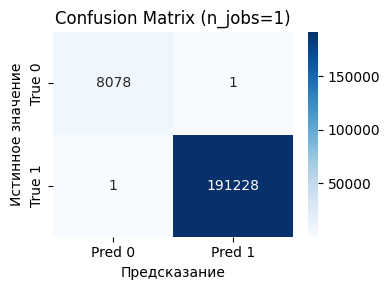

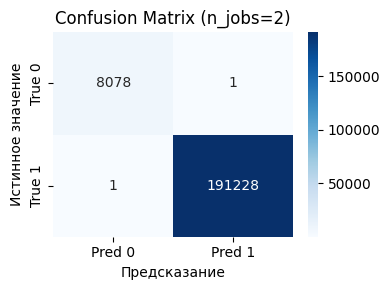

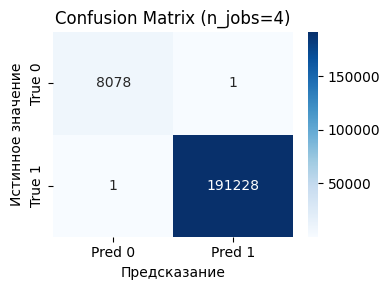

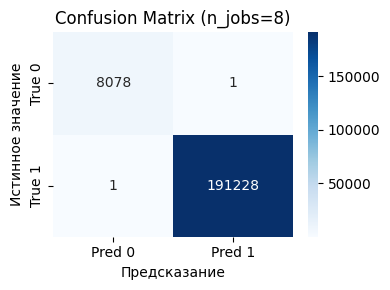

   n_jobs  train_time  accuracy        f1  precision
0       1   42.215325   0.99999  0.999995   0.999995
1       2   23.343724   0.99999  0.999995   0.999995
2       4   13.666058   0.99999  0.999995   0.999995
3       8   11.482005   0.99999  0.999995   0.999995


In [11]:
import time
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

n_jobs_list = [1, 2, 4, 8]
results_seq = []

for n in n_jobs_list:
    start = time.time()
    model = XGBClassifier(n_estimators=100, max_depth=6, random_state=42, n_jobs=n)
    model.fit(X_train_b_bal, y_train_b_bal)
    duration = time.time() - start

    y_pred = model.predict(X_test_b)
    acc = accuracy_score(y_test_b, y_pred)
    f1 = f1_score(y_test_b, y_pred)
    precision = precision_score(y_test_b, y_pred)

    # Матрица ошибок
    cm = confusion_matrix(y_test_b, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
    plt.title(f'Confusion Matrix (n_jobs={n})')
    plt.xlabel('Предсказание')
    plt.ylabel('Истинное значение')
    plt.tight_layout()
    plt.show()

    # Сохраняем всё в results
    results_seq.append({
        'n_jobs': n,
        'train_time': duration,
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'conf_matrix': cm.tolist()  # сохраняем как список для DataFrame
    })

results_seq_df = pd.DataFrame(results_seq)
print(results_seq_df[['n_jobs', 'train_time', 'accuracy', 'f1', 'precision']])


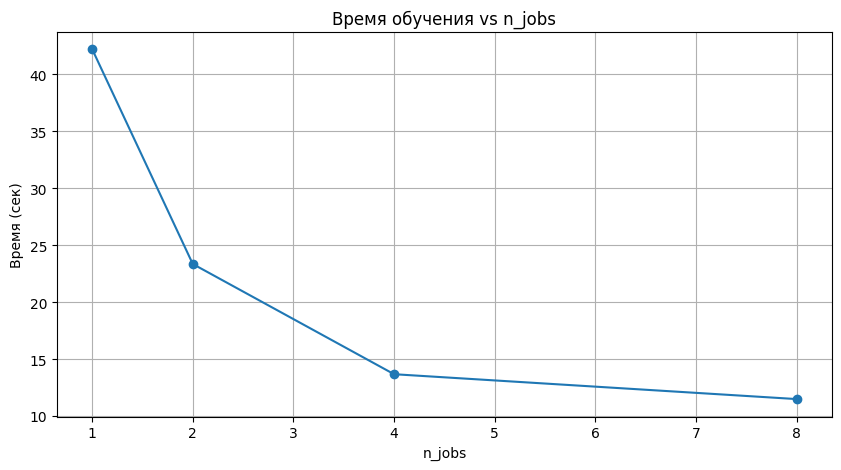

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(results_seq_df['n_jobs'], results_seq_df['train_time'], marker='o')
plt.title('Время обучения vs n_jobs')
plt.xlabel('n_jobs')
plt.ylabel('Время (сек)')
plt.grid(True)
plt.show()

# plt.figure(figsize=(10, 5))
# plt.plot(results_seq_df['n_jobs'], results_seq_df['accuracy'], marker='o', label='Accuracy')
# plt.plot(results_seq_df['n_jobs'], results_seq_df['f1'], marker='o', label='F1')
# plt.plot(results_seq_df['n_jobs'], results_seq_df['precision'], marker='o', label='Precision')
# plt.title('Метрики качества vs n_jobs')
# plt.xlabel('n_jobs')
# plt.ylabel('Значение')
# plt.legend()
# plt.grid(True)
# plt.show()


# Train XGBoost classifier (sequential execution)

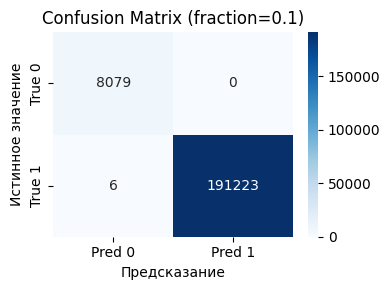

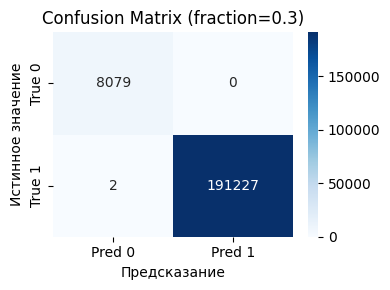

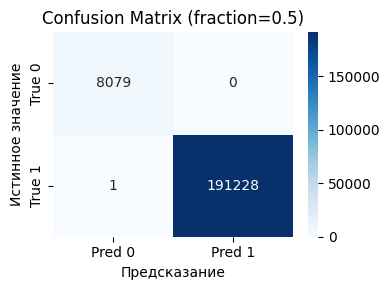

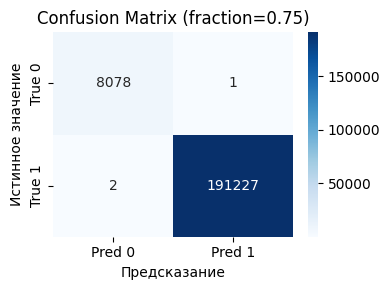

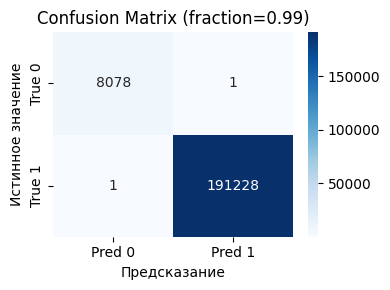

   fraction  train_time  accuracy        f1  precision
0      0.10    1.244402  0.999970  0.999984   1.000000
1      0.30    3.739320  0.999990  0.999995   1.000000
2      0.50    6.890603  0.999995  0.999997   1.000000
3      0.75   10.191446  0.999985  0.999992   0.999995
4      0.99   13.838704  0.999990  0.999995   0.999995


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import time

fractions = [0.1, 0.3, 0.5, 0.75, 0.99]
results_par = []

for frac in fractions:
    X_sub, _, y_sub, _ = train_test_split(
        X_train_b_bal, y_train_b_bal, train_size=frac, random_state=42, stratify=y_train_b_bal
    )
    start = time.time()
    model = XGBClassifier(n_estimators=100, max_depth=6, random_state=42, n_jobs=4)
    model.fit(X_sub, y_sub)
    duration = time.time() - start

    y_pred = model.predict(X_test_b)
    acc = accuracy_score(y_test_b, y_pred)
    f1 = f1_score(y_test_b, y_pred)
    precision = precision_score(y_test_b, y_pred)

    # Confusion matrix
    cm = confusion_matrix(y_test_b, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
    plt.title(f'Confusion Matrix (fraction={frac})')
    plt.xlabel('Предсказание')
    plt.ylabel('Истинное значение')
    plt.tight_layout()
    plt.show()

    results_par.append({
        'fraction': frac,
        'train_time': duration,
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'conf_matrix': cm.tolist()
    })

results_par_df = pd.DataFrame(results_par)
print(results_par_df[['fraction', 'train_time', 'accuracy', 'f1', 'precision']])



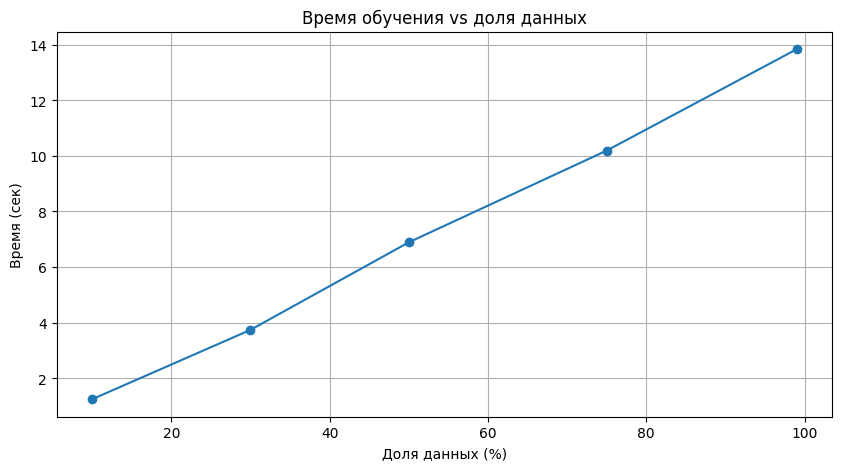

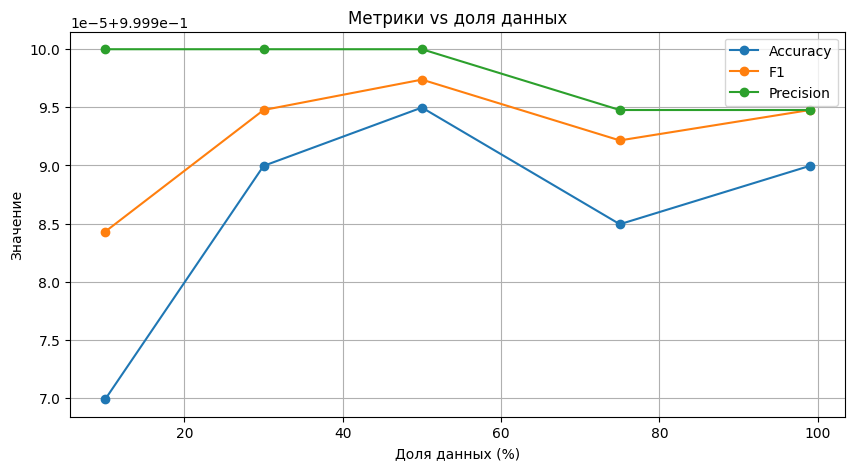

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(results_par_df['fraction']*100, results_par_df['train_time'], marker='o')
plt.title('Время обучения vs доля данных')
plt.xlabel('Доля данных (%)')
plt.ylabel('Время (сек)')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(results_par_df['fraction']*100, results_par_df['accuracy'], marker='o', label='Accuracy')
plt.plot(results_par_df['fraction']*100, results_par_df['f1'], marker='o', label='F1')
plt.plot(results_par_df['fraction']*100, results_par_df['precision'], marker='o', label='Precision')
plt.title('Метрики vs доля данных')
plt.xlabel('Доля данных (%)')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.show()


# -----------------Multiclass XGBoost(Preparation)-----------------

Adding multiclass lables

In [15]:
from sklearn.preprocessing import LabelEncoder

df_multi = df.copy()
le = LabelEncoder()
df_multi['multi_label'] = le.fit_transform(df_multi['label'])
df_multi.drop(columns=['label'], inplace=True)

print(df_multi['multi_label'].value_counts())
print("Коды меток:", list(le.classes_))

X_multi = df_multi.drop(columns=['multi_label'])
y_multi = df_multi['multi_label']

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_multi, y_multi, test_size=0.2, random_state=42, stratify=y_multi
)

print("Train size:", X_train_m.shape, "Test size:", X_test_m.shape)

smote = SMOTE(random_state=42)
X_train_m_bal, y_train_m_bal = smote.fit_resample(X_train_m, y_train_m)
print("Classes:", le.classes_)
print("Train:", X_train_m_bal.shape, "Test:", X_test_m.shape)

multi_label
9     237665
8     122573
7     107685
6     102195
5     100182
4      85227
10     81982
1      59718
0      40395
3      29849
2      29068
Name: count, dtype: int64
Коды меток: ['benign', 'gafgyt_combo', 'gafgyt_junk', 'gafgyt_scan', 'gafgyt_tcp', 'gafgyt_udp', 'mirai_ack', 'mirai_scan', 'mirai_syn', 'mirai_udp', 'mirai_udpplain']
Train size: (797231, 116) Test size: (199308, 116)
Classes: ['benign' 'gafgyt_combo' 'gafgyt_junk' 'gafgyt_scan' 'gafgyt_tcp'
 'gafgyt_udp' 'mirai_ack' 'mirai_scan' 'mirai_syn' 'mirai_udp'
 'mirai_udpplain']
Train: (2091452, 116) Test: (199308, 116)


# Train XGBoost classifier (parallel execution)

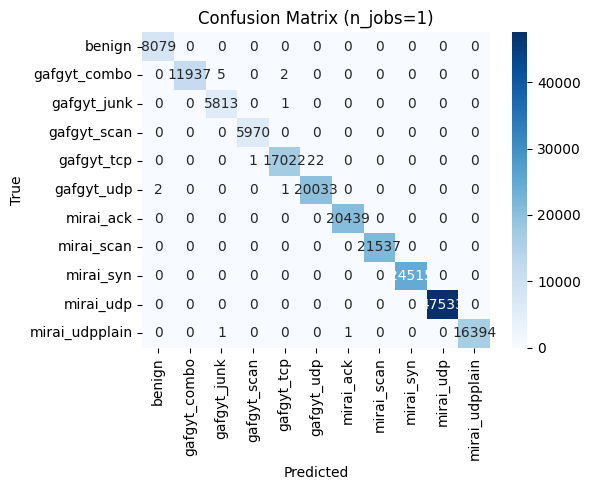


Classification Report (n_jobs=1):
                precision    recall  f1-score   support

        benign       1.00      1.00      1.00      8079
  gafgyt_combo       1.00      1.00      1.00     11944
   gafgyt_junk       1.00      1.00      1.00      5814
   gafgyt_scan       1.00      1.00      1.00      5970
    gafgyt_tcp       1.00      1.00      1.00     17045
    gafgyt_udp       1.00      1.00      1.00     20036
     mirai_ack       1.00      1.00      1.00     20439
    mirai_scan       1.00      1.00      1.00     21537
     mirai_syn       1.00      1.00      1.00     24515
     mirai_udp       1.00      1.00      1.00     47533
mirai_udpplain       1.00      1.00      1.00     16396

      accuracy                           1.00    199308
     macro avg       1.00      1.00      1.00    199308
  weighted avg       1.00      1.00      1.00    199308

n_jobs=1  time=421.09s  acc=0.9998  f1=0.9998  precision=0.9997


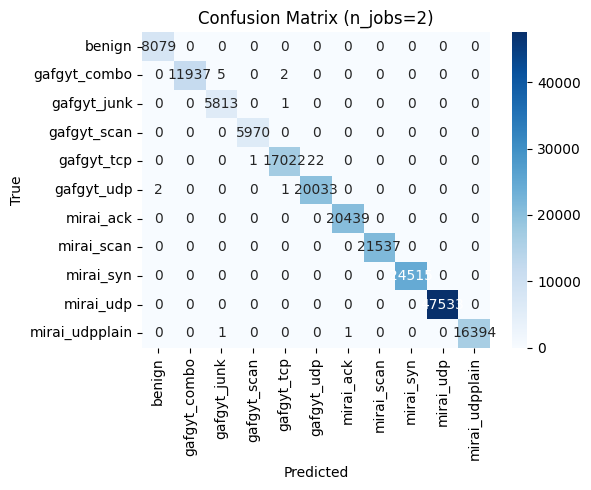


Classification Report (n_jobs=2):
                precision    recall  f1-score   support

        benign       1.00      1.00      1.00      8079
  gafgyt_combo       1.00      1.00      1.00     11944
   gafgyt_junk       1.00      1.00      1.00      5814
   gafgyt_scan       1.00      1.00      1.00      5970
    gafgyt_tcp       1.00      1.00      1.00     17045
    gafgyt_udp       1.00      1.00      1.00     20036
     mirai_ack       1.00      1.00      1.00     20439
    mirai_scan       1.00      1.00      1.00     21537
     mirai_syn       1.00      1.00      1.00     24515
     mirai_udp       1.00      1.00      1.00     47533
mirai_udpplain       1.00      1.00      1.00     16396

      accuracy                           1.00    199308
     macro avg       1.00      1.00      1.00    199308
  weighted avg       1.00      1.00      1.00    199308

n_jobs=2  time=239.49s  acc=0.9998  f1=0.9998  precision=0.9997


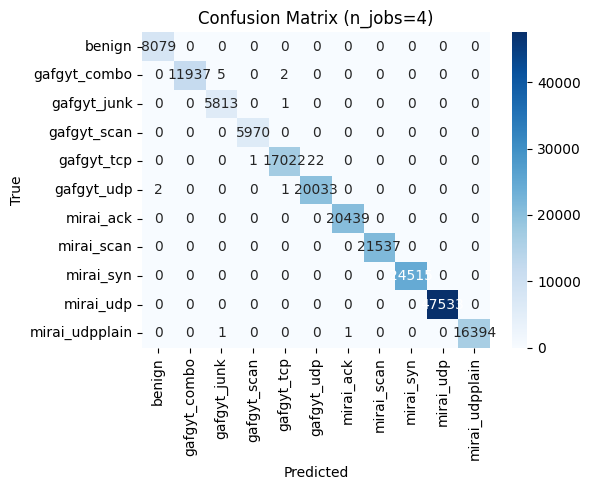


Classification Report (n_jobs=4):
                precision    recall  f1-score   support

        benign       1.00      1.00      1.00      8079
  gafgyt_combo       1.00      1.00      1.00     11944
   gafgyt_junk       1.00      1.00      1.00      5814
   gafgyt_scan       1.00      1.00      1.00      5970
    gafgyt_tcp       1.00      1.00      1.00     17045
    gafgyt_udp       1.00      1.00      1.00     20036
     mirai_ack       1.00      1.00      1.00     20439
    mirai_scan       1.00      1.00      1.00     21537
     mirai_syn       1.00      1.00      1.00     24515
     mirai_udp       1.00      1.00      1.00     47533
mirai_udpplain       1.00      1.00      1.00     16396

      accuracy                           1.00    199308
     macro avg       1.00      1.00      1.00    199308
  weighted avg       1.00      1.00      1.00    199308

n_jobs=4  time=141.57s  acc=0.9998  f1=0.9998  precision=0.9997


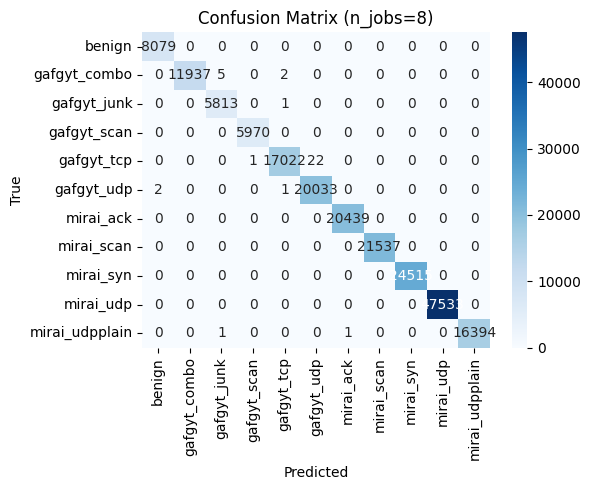


Classification Report (n_jobs=8):
                precision    recall  f1-score   support

        benign       1.00      1.00      1.00      8079
  gafgyt_combo       1.00      1.00      1.00     11944
   gafgyt_junk       1.00      1.00      1.00      5814
   gafgyt_scan       1.00      1.00      1.00      5970
    gafgyt_tcp       1.00      1.00      1.00     17045
    gafgyt_udp       1.00      1.00      1.00     20036
     mirai_ack       1.00      1.00      1.00     20439
    mirai_scan       1.00      1.00      1.00     21537
     mirai_syn       1.00      1.00      1.00     24515
     mirai_udp       1.00      1.00      1.00     47533
mirai_udpplain       1.00      1.00      1.00     16396

      accuracy                           1.00    199308
     macro avg       1.00      1.00      1.00    199308
  weighted avg       1.00      1.00      1.00    199308

n_jobs=8  time=143.28s  acc=0.9998  f1=0.9998  precision=0.9997

Параллельное (vary n_jobs):
   n_jobs  train_time_sec  ac

In [16]:
from sklearn.metrics import precision_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

n_jobs_list = [1, 2, 4, 8]
results_seq_multi = []

for n in n_jobs_list:
    start = time.time()
    model = XGBClassifier(
        objective='multi:softmax',
        num_class=len(le.classes_),
        n_estimators=100,
        max_depth=6,
        random_state=42,
        n_jobs=n
    )
    model.fit(X_train_m_bal, y_train_m_bal)
    duration = time.time() - start

    y_pred = model.predict(X_test_m)
    acc = accuracy_score(y_test_m, y_pred)
    f1 = f1_score(y_test_m, y_pred, average='weighted')
    precision = precision_score(y_test_m, y_pred, average='macro')

    # Confusion matrix
    cm = confusion_matrix(y_test_m, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix (n_jobs={n})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # Classification Report (для подробной оценки по каждому классу)
    print(f"\nClassification Report (n_jobs={n}):")
    print(classification_report(y_test_m, y_pred, target_names=le.classes_))

    results_seq_multi.append({
        'n_jobs': n,
        'train_time_sec': duration,
        'accuracy': acc,
        'f1_weighted': f1,
        'precision_macro': precision
    })
    print(f"n_jobs={n}  time={duration:.2f}s  acc={acc:.4f}  f1={f1:.4f}  precision={precision:.4f}")

df_seq_multi = pd.DataFrame(results_seq_multi)
print("\nПараллельное (vary n_jobs):")
print(df_seq_multi[['n_jobs', 'train_time_sec', 'accuracy', 'f1_weighted', 'precision_macro']])


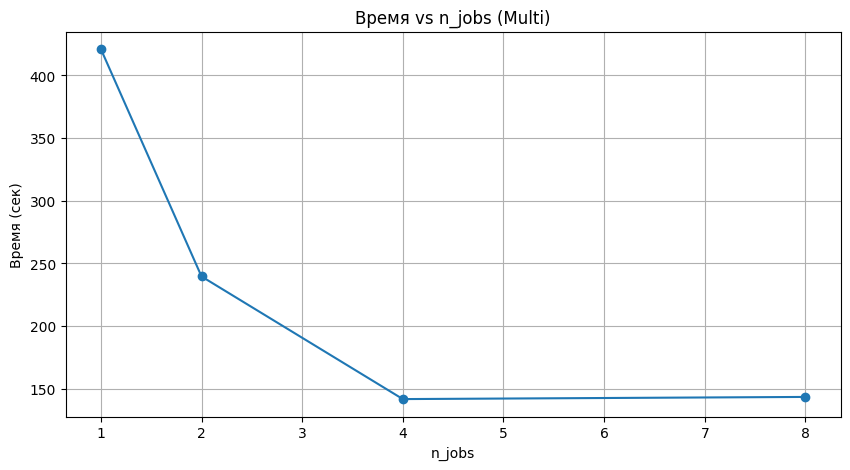

In [43]:
plt.figure(figsize=(10,5))
plt.plot(df_seq_multi['n_jobs'], df_seq_multi['train_time_sec'], marker='o')
plt.title('Время vs n_jobs (Multi)')
plt.xlabel('n_jobs')
plt.ylabel('Время (сек)')
plt.grid(True)
plt.show()

# plt.figure(figsize=(10,5))
# plt.plot(df_seq_multi['n_jobs'], df_seq_multi['accuracy'], marker='o', label='Accuracy')
# plt.plot(df_seq_multi['n_jobs'], df_seq_multi['f1_weighted'], marker='o', label='F1 (weighted)')
# plt.plot(df_seq_multi['n_jobs'], df_seq_multi['precision_macro'], marker='o', label='Precision (macro)')
# plt.title('Метрики vs n_jobs (Multi)')
# plt.xlabel('n_jobs')
# plt.ylabel('Значение')
# plt.legend()
# plt.grid(True)
# plt.show()


# Train XGBoost classifier (sequential execution)

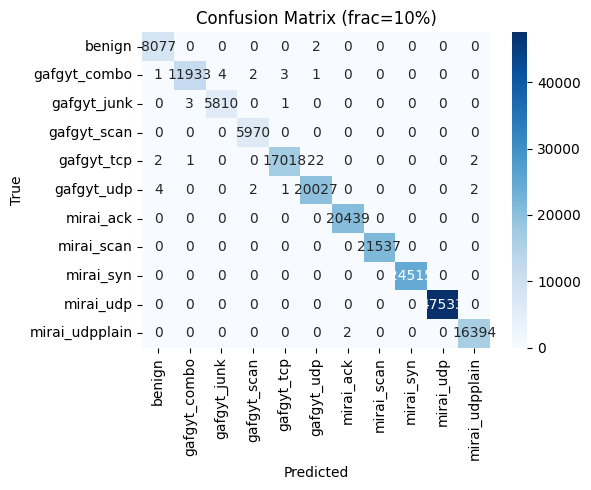


Classification Report (frac=10%):
                precision    recall  f1-score   support

        benign       1.00      1.00      1.00      8079
  gafgyt_combo       1.00      1.00      1.00     11944
   gafgyt_junk       1.00      1.00      1.00      5814
   gafgyt_scan       1.00      1.00      1.00      5970
    gafgyt_tcp       1.00      1.00      1.00     17045
    gafgyt_udp       1.00      1.00      1.00     20036
     mirai_ack       1.00      1.00      1.00     20439
    mirai_scan       1.00      1.00      1.00     21537
     mirai_syn       1.00      1.00      1.00     24515
     mirai_udp       1.00      1.00      1.00     47533
mirai_udpplain       1.00      1.00      1.00     16396

      accuracy                           1.00    199308
     macro avg       1.00      1.00      1.00    199308
  weighted avg       1.00      1.00      1.00    199308

frac=10%  time=16.11s  acc=0.9997  f1=0.9997  precision=0.9996


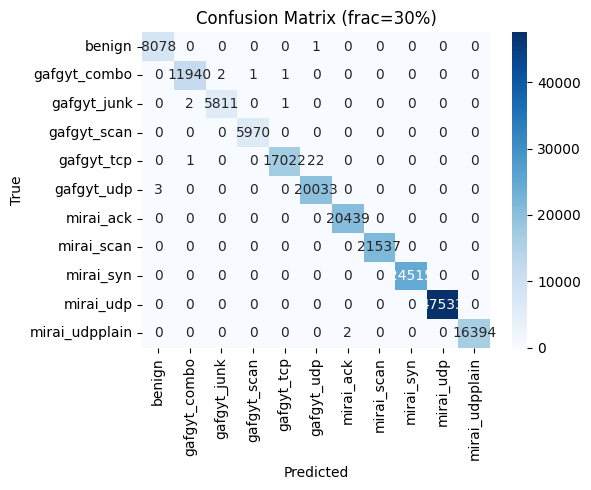


Classification Report (frac=30%):
                precision    recall  f1-score   support

        benign       1.00      1.00      1.00      8079
  gafgyt_combo       1.00      1.00      1.00     11944
   gafgyt_junk       1.00      1.00      1.00      5814
   gafgyt_scan       1.00      1.00      1.00      5970
    gafgyt_tcp       1.00      1.00      1.00     17045
    gafgyt_udp       1.00      1.00      1.00     20036
     mirai_ack       1.00      1.00      1.00     20439
    mirai_scan       1.00      1.00      1.00     21537
     mirai_syn       1.00      1.00      1.00     24515
     mirai_udp       1.00      1.00      1.00     47533
mirai_udpplain       1.00      1.00      1.00     16396

      accuracy                           1.00    199308
     macro avg       1.00      1.00      1.00    199308
  weighted avg       1.00      1.00      1.00    199308

frac=30%  time=54.11s  acc=0.9998  f1=0.9998  precision=0.9998


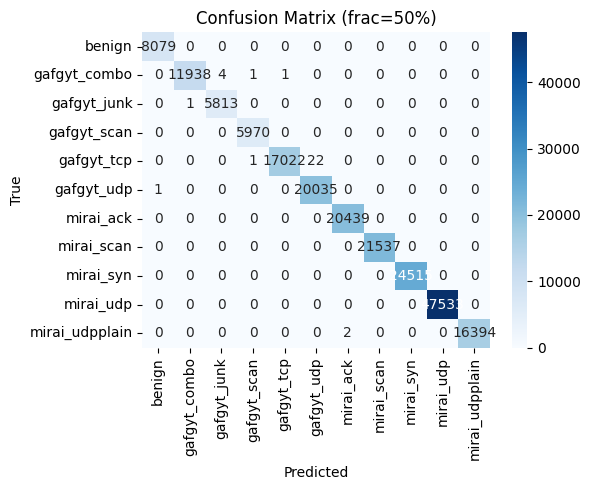


Classification Report (frac=50%):
                precision    recall  f1-score   support

        benign       1.00      1.00      1.00      8079
  gafgyt_combo       1.00      1.00      1.00     11944
   gafgyt_junk       1.00      1.00      1.00      5814
   gafgyt_scan       1.00      1.00      1.00      5970
    gafgyt_tcp       1.00      1.00      1.00     17045
    gafgyt_udp       1.00      1.00      1.00     20036
     mirai_ack       1.00      1.00      1.00     20439
    mirai_scan       1.00      1.00      1.00     21537
     mirai_syn       1.00      1.00      1.00     24515
     mirai_udp       1.00      1.00      1.00     47533
mirai_udpplain       1.00      1.00      1.00     16396

      accuracy                           1.00    199308
     macro avg       1.00      1.00      1.00    199308
  weighted avg       1.00      1.00      1.00    199308

frac=50%  time=70.95s  acc=0.9998  f1=0.9998  precision=0.9998


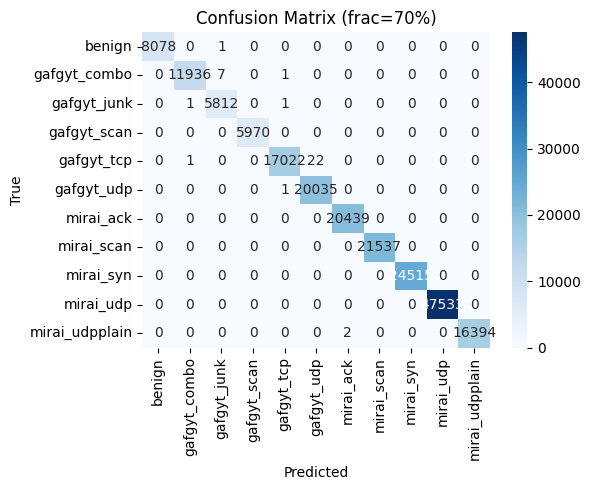


Classification Report (frac=70%):
                precision    recall  f1-score   support

        benign       1.00      1.00      1.00      8079
  gafgyt_combo       1.00      1.00      1.00     11944
   gafgyt_junk       1.00      1.00      1.00      5814
   gafgyt_scan       1.00      1.00      1.00      5970
    gafgyt_tcp       1.00      1.00      1.00     17045
    gafgyt_udp       1.00      1.00      1.00     20036
     mirai_ack       1.00      1.00      1.00     20439
    mirai_scan       1.00      1.00      1.00     21537
     mirai_syn       1.00      1.00      1.00     24515
     mirai_udp       1.00      1.00      1.00     47533
mirai_udpplain       1.00      1.00      1.00     16396

      accuracy                           1.00    199308
     macro avg       1.00      1.00      1.00    199308
  weighted avg       1.00      1.00      1.00    199308

frac=70%  time=104.05s  acc=0.9998  f1=0.9998  precision=0.9997


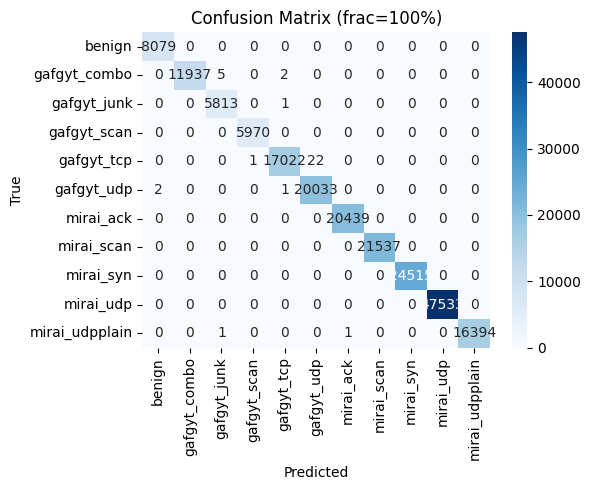


Classification Report (frac=100%):
                precision    recall  f1-score   support

        benign       1.00      1.00      1.00      8079
  gafgyt_combo       1.00      1.00      1.00     11944
   gafgyt_junk       1.00      1.00      1.00      5814
   gafgyt_scan       1.00      1.00      1.00      5970
    gafgyt_tcp       1.00      1.00      1.00     17045
    gafgyt_udp       1.00      1.00      1.00     20036
     mirai_ack       1.00      1.00      1.00     20439
    mirai_scan       1.00      1.00      1.00     21537
     mirai_syn       1.00      1.00      1.00     24515
     mirai_udp       1.00      1.00      1.00     47533
mirai_udpplain       1.00      1.00      1.00     16396

      accuracy                           1.00    199308
     macro avg       1.00      1.00      1.00    199308
  weighted avg       1.00      1.00      1.00    199308

frac=100%  time=144.26s  acc=0.9998  f1=0.9998  precision=0.9997

Последовательное (vary data size):
   fraction  train_t

In [18]:
from sklearn.metrics import precision_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import time
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

fractions = [0.1, 0.3, 0.5, 0.7, 1.0]
results_par_multi = []
FIXED_N_JOBS = 4

for frac in fractions:
    # берём долю сбалансированных тренировочных данных
    n_samples = int(len(X_train_m_bal) * frac)
    X_sub = X_train_m_bal.iloc[:n_samples]
    y_sub = y_train_m_bal.iloc[:n_samples]

    start = time.time()
    model = XGBClassifier(
        objective='multi:softmax',
        num_class=len(le.classes_),
        n_estimators=100,
        max_depth=6,
        random_state=42,
        n_jobs=FIXED_N_JOBS
    )
    model.fit(X_sub, y_sub)
    duration = time.time() - start

    y_pred = model.predict(X_test_m)
    acc = accuracy_score(y_test_m, y_pred)
    f1 = f1_score(y_test_m, y_pred, average='weighted')
    precision = precision_score(y_test_m, y_pred, average='macro')

    # Confusion matrix
    cm = confusion_matrix(y_test_m, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix (frac={int(frac*100)}%)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # Classification Report
    print(f"\nClassification Report (frac={int(frac*100)}%):")
    print(classification_report(y_test_m, y_pred, target_names=le.classes_))

    results_par_multi.append({
        'fraction': frac,
        'train_time_sec': duration,
        'accuracy': acc,
        'f1_weighted': f1,
        'precision_macro': precision
    })
    print(f"frac={int(frac*100)}%  time={duration:.2f}s  acc={acc:.4f}  f1={f1:.4f}  precision={precision:.4f}")

df_par_multi = pd.DataFrame(results_par_multi)
print("\nПоследовательное (vary data size):")
print(df_par_multi)



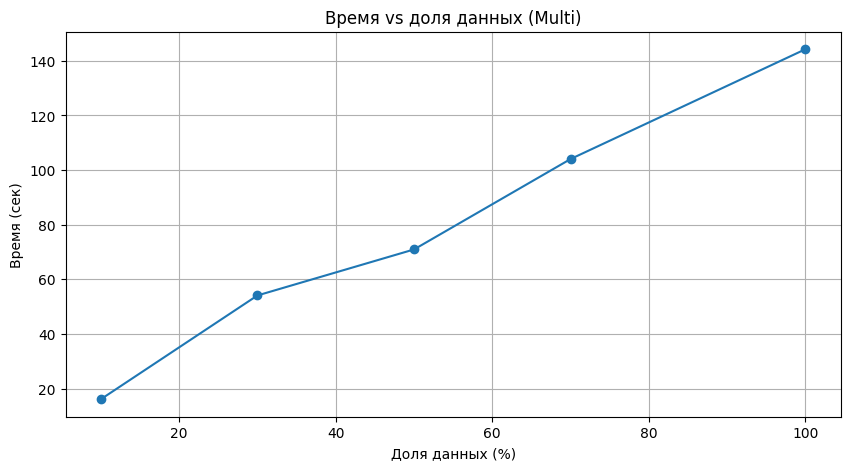

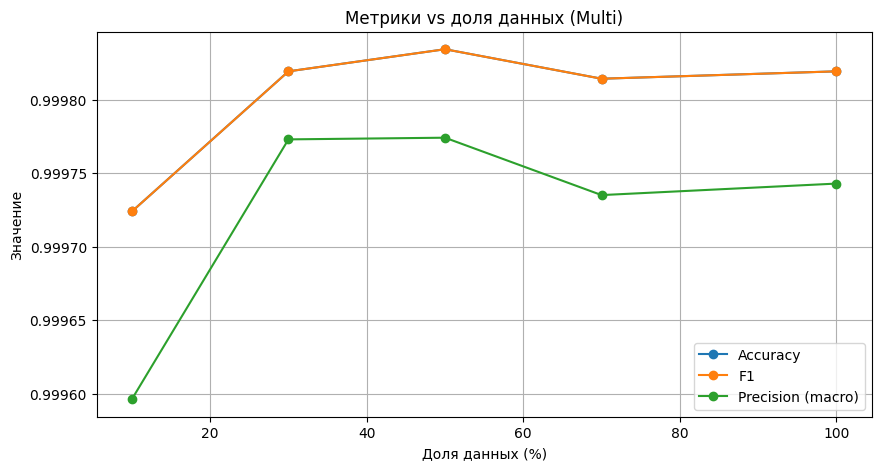

In [19]:
plt.figure(figsize=(10,5))
plt.plot(df_par_multi['fraction']*100, df_par_multi['train_time_sec'], marker='o')
plt.title('Время vs доля данных (Multi)')
plt.xlabel('Доля данных (%)')
plt.ylabel('Время (сек)')
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(df_par_multi['fraction']*100, df_par_multi['accuracy'], marker='o', label='Accuracy')
plt.plot(df_par_multi['fraction']*100, df_par_multi['f1_weighted'], marker='o', label='F1')
plt.plot(df_par_multi['fraction']*100, df_par_multi['precision_macro'], marker='o', label='Precision (macro)')
plt.title('Метрики vs доля данных (Multi)')
plt.xlabel('Доля данных (%)')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.show()


# -------------------Isolation Forest for searching anomalies in data-------------------

Preparing lables and separating train/test datasets.

In [20]:
# Подготовка данных для аномалий (Isolation Forest)
df_ano = df.copy()
df_benign = df_ano[df_ano['label'].str.lower() == 'benign']
X_ano_train_full = df_benign.drop(columns=['label'])
X_ano_test = df_ano.drop(columns=['label'])
y_ano_test = df_ano['label'].apply(lambda x: 0 if x.lower() == 'benign' else 1)

print("benign train shape:", X_ano_train_full.shape, "test shape:", X_ano_test.shape)


benign train shape: (40395, 116) test shape: (996539, 116)


# Train Isolation Forest (sequential execution)

fit times: [0.3116734027862549, 0.5707216262817383, 0.7318081855773926, 0.9793734550476074, 1.285205602645874]
f1 scores: [0.9996380480538283, 0.9997835522731716, 0.9997898248017191, 0.999766825915156, 0.9997887793748288]
accuracy scores: [0.9993055966700751, 0.9995845621696692, 0.9995966038459106, 0.9995524510330253, 0.9995945968998704]
precision scores: [0.9998639757583875, 0.9995671982253036, 0.9995797379321015, 0.9995337605452702, 0.9995776479591196]
recall scores: [0.9994122224267474, 1.0, 1.0, 1.0, 1.0]
confusion matrices: [array([[ 40265,    130],
       [   562, 955582]]), array([[ 39981,    414],
       [     0, 956144]]), array([[ 39993,    402],
       [     0, 956144]]), array([[ 39949,    446],
       [     0, 956144]]), array([[ 39991,    404],
       [     0, 956144]])]


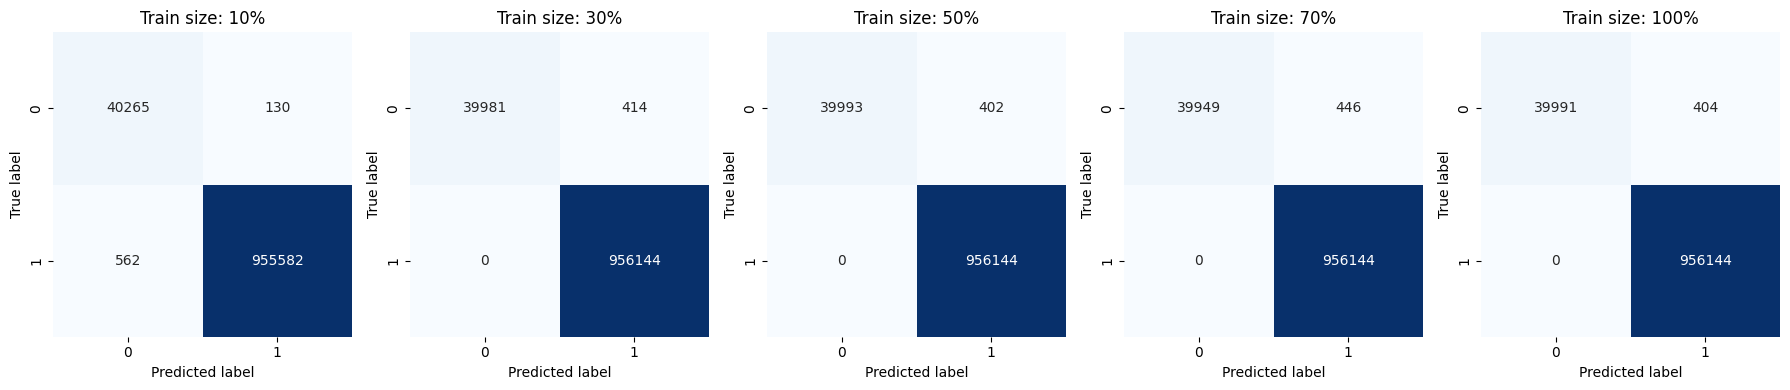

In [39]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Размеры обучающих выборок
train_sizes = [0.1, 0.3, 0.5, 0.7, 1.0]

# Списки для хранения результатов
fit_times = []
f1_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []
confusion_matrices = []

# Основной цикл по размерам выборок
for size in train_sizes:
    n_samples = int(len(X_ano_train_full) * size)
    X_sub = X_ano_train_full.iloc[:n_samples]
    
    # Обучение модели Isolation Forest
    start = time.time()
    iso = IsolationForest(n_estimators=200,        # Увеличено количество деревьев
                          max_samples=0.7,         # Используем 70% данных для каждого дерева
                          contamination=0.01,      # Устанавливаем долю аномальных данных
                          max_features=X_ano_train_full.shape[1], # Используем все признаки
                          n_jobs=1,                # Оставляем 1 поток
                          random_state=42)
    iso.fit(X_sub)
    fit_times.append(time.time() - start)
    
    # Предсказания (1 = норм, -1 = аномалия) → преобразуем в бинарный вид (1 = аномалия)
    y_pred = iso.predict(X_ano_test)
    y_pred_bin = np.where(y_pred == 1, 0, 1)
    
    # Метрики
    f1_scores.append(f1_score(y_ano_test, y_pred_bin))
    accuracy_scores.append(accuracy_score(y_ano_test, y_pred_bin))
    precision_scores.append(precision_score(y_ano_test, y_pred_bin))
    recall_scores.append(recall_score(y_ano_test, y_pred_bin))
    
    # Матрица ошибок
    confusion_matrices.append(confusion_matrix(y_ano_test, y_pred_bin))

# Вывод числовых результатов
print("fit times:", fit_times)
print("f1 scores:", f1_scores)
print("accuracy scores:", accuracy_scores)
print("precision scores:", precision_scores)
print("recall scores:", recall_scores)
print("confusion matrices:", confusion_matrices)

# Визуализация матриц ошибок
fig, axes = plt.subplots(1, len(train_sizes), figsize=(18, 4))

for i, (cm, size) in enumerate(zip(confusion_matrices, train_sizes)):
    ax = axes[i]
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_title(f"Train size: {int(size * 100)}%")
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

plt.tight_layout()
plt.show()



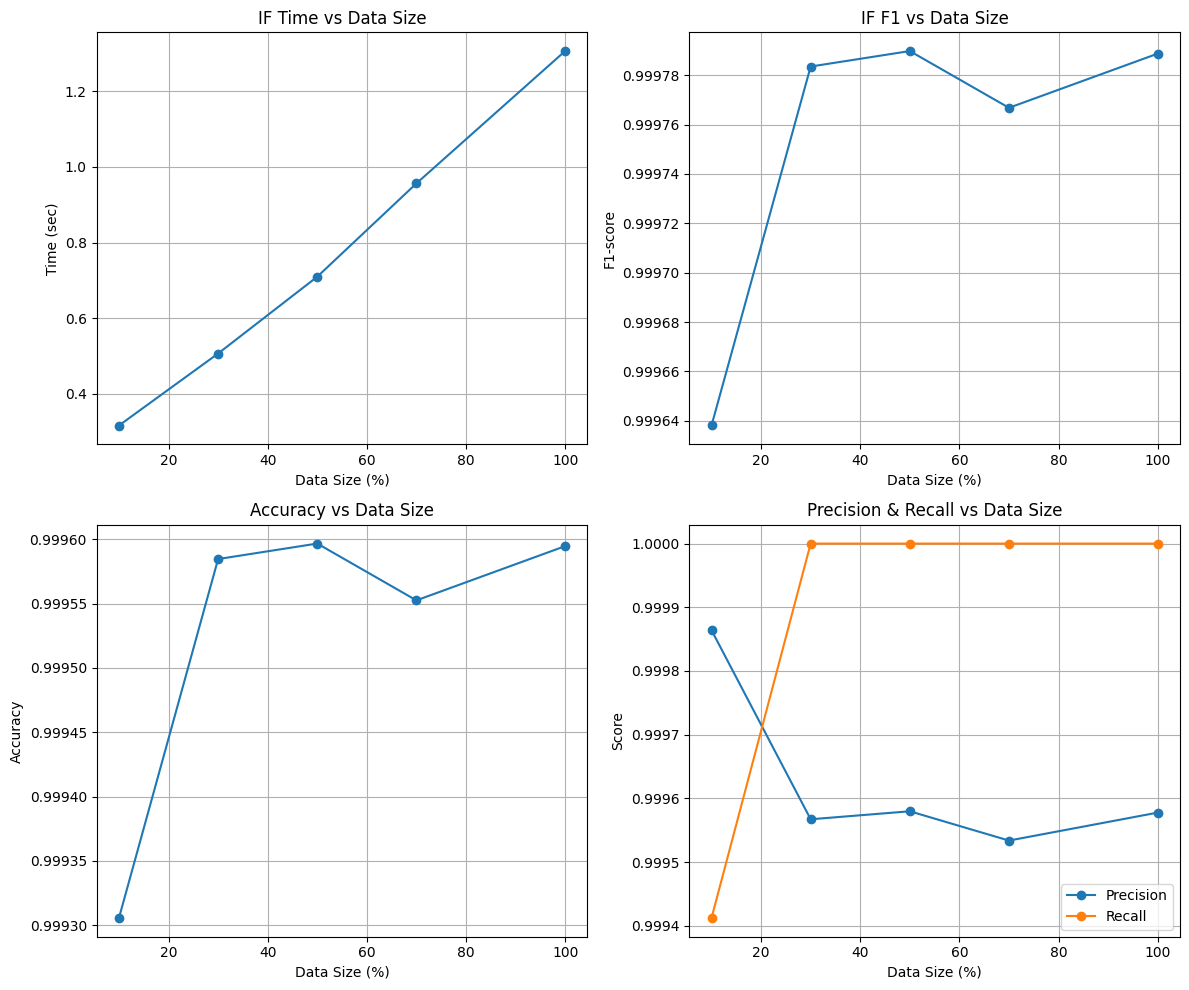

In [35]:
import matplotlib.pyplot as plt

# Графики последовательного IF
plt.figure(figsize=(12, 10))

# График времени обучения vs размера данных
plt.subplot(2, 2, 1)
plt.plot([int(s*100) for s in train_sizes], fit_times, marker='o')
plt.title('IF Time vs Data Size')
plt.xlabel('Data Size (%)')
plt.ylabel('Time (sec)')
plt.grid(True)

# График F1-score vs размера данных
plt.subplot(2, 2, 2)
plt.plot([int(s*100) for s in train_sizes], f1_scores, marker='o')
plt.title('IF F1 vs Data Size')
plt.xlabel('Data Size (%)')
plt.ylabel('F1-score')
plt.grid(True)

# График точности vs размера данных
plt.subplot(2, 2, 3)
plt.plot([int(s*100) for s in train_sizes], accuracy_scores, marker='o')
plt.title('Accuracy vs Data Size')
plt.xlabel('Data Size (%)')
plt.ylabel('Accuracy')
plt.grid(True)

# График точности vs размера данных
plt.subplot(2, 2, 4)
plt.plot([int(s*100) for s in train_sizes], precision_scores, marker='o', label="Precision")
plt.plot([int(s*100) for s in train_sizes], recall_scores, marker='o', label="Recall")
plt.title('Precision & Recall vs Data Size')
plt.xlabel('Data Size (%)')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Train Isolation Forest (parallel execution)

times: [1.4003427028656006, 1.0329442024230957, 0.8887989521026611, 0.8374617099761963]
f1 scores: [0.9997887793748288, 0.9997887793748288, 0.9997887793748288, 0.9997887793748288]
accuracy scores: [0.9995945968998704, 0.9995945968998704, 0.9995945968998704, 0.9995945968998704]
precision scores: [0.9995776479591196, 0.9995776479591196, 0.9995776479591196, 0.9995776479591196]
recall scores: [1.0, 1.0, 1.0, 1.0]


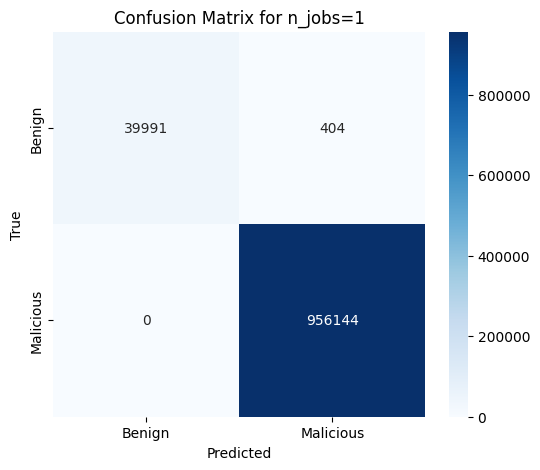

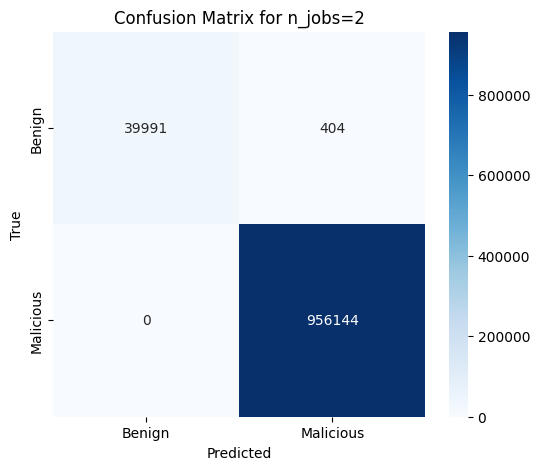

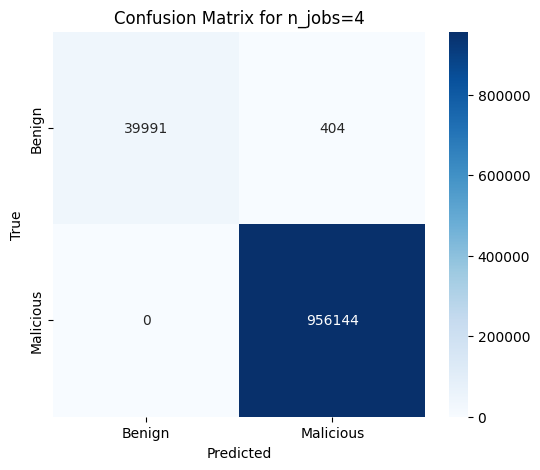

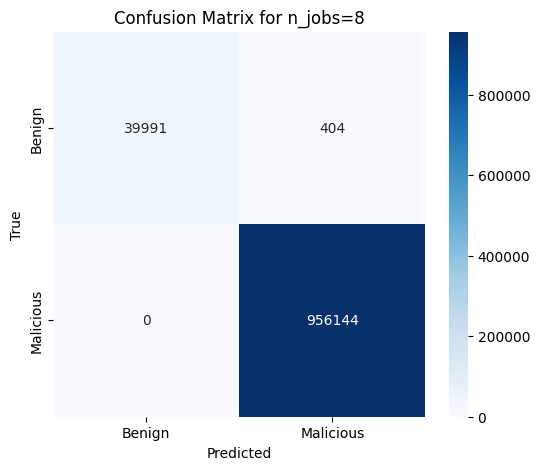

In [36]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Параллельное выполнение Isolation Forest (varying n_jobs)
n_jobs_list = [1, 2, 4, 8]
times = []
f1s = []
accuracy_scores = []
precision_scores = []
recall_scores = []
confusion_matrices = []

for n in n_jobs_list:
    start = time.time()
    iso = IsolationForest(n_estimators=200,        # Увеличено количество деревьев
                          max_samples=0.7,         # Используем 70% данных для каждого дерева
                          contamination=0.01,      # Устанавливаем долю аномальных данных
                          max_features=X_ano_train_full.shape[1], # Используем все признаки
                          n_jobs=n,                # Оставляем 1 поток
                          random_state=42)

    iso.fit(X_ano_train_full)
    times.append(time.time() - start)
    
    # Прогнозирование
    y_pred = iso.predict(X_ano_test)
    y_pred_bin = np.where(y_pred == 1, 0, 1)
    
    # Вычисление метрик
    f1s.append(f1_score(y_ano_test, y_pred_bin))
    accuracy_scores.append(accuracy_score(y_ano_test, y_pred_bin))
    precision_scores.append(precision_score(y_ano_test, y_pred_bin))
    recall_scores.append(recall_score(y_ano_test, y_pred_bin))
    
    # Матрица ошибок
    cm = confusion_matrix(y_ano_test, y_pred_bin)
    confusion_matrices.append(cm)

# Печать всех метрик
print("times:", times)
print("f1 scores:", f1s)
print("accuracy scores:", accuracy_scores)
print("precision scores:", precision_scores)
print("recall scores:", recall_scores)

# Визуализация матриц ошибок
for i, cm in enumerate(confusion_matrices):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
    plt.title(f"Confusion Matrix for n_jobs={n_jobs_list[i]}")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


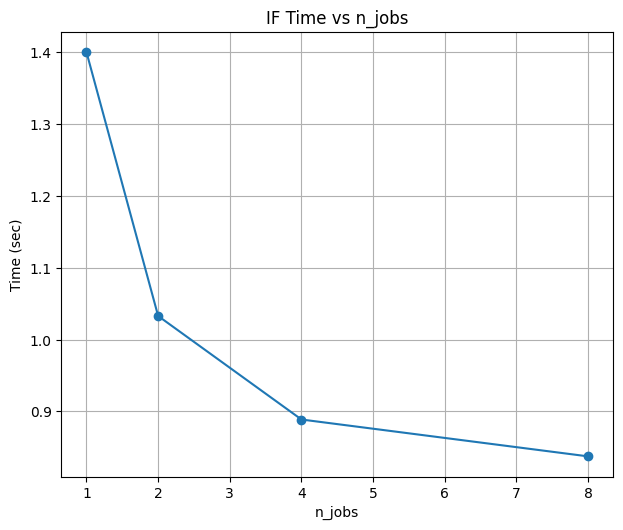

In [42]:
import matplotlib.pyplot as plt

# Графики параллельного IF
plt.figure(figsize=(12, 10))

# График времени работы модели vs количества потоков
plt.subplot(2, 2, 1)
plt.plot(n_jobs_list, times, marker='o')
plt.title('IF Time vs n_jobs')
plt.xlabel('n_jobs')
plt.ylabel('Time (sec)')
plt.grid(True)

# # График F1-score vs количества потоков
# plt.subplot(2, 2, 2)
# plt.plot(n_jobs_list, f1s, marker='o')
# plt.title('IF F1 vs n_jobs')
# plt.xlabel('n_jobs')
# plt.ylabel('F1-score')
# plt.grid(True)

# # График точности vs количества потоков
# plt.subplot(2, 2, 3)
# plt.plot(n_jobs_list, accuracy_scores, marker='o')
# plt.title('Accuracy vs n_jobs')
# plt.xlabel('n_jobs')
# plt.ylabel('Accuracy')
# plt.grid(True)

# # График точности и полноты vs количества потоков
# plt.subplot(2, 2, 4)
# plt.plot(n_jobs_list, precision_scores, marker='o', label="Precision")
# plt.plot(n_jobs_list, recall_scores, marker='o', label="Recall")
# plt.title('Precision & Recall vs n_jobs')
# plt.xlabel('n_jobs')
# plt.ylabel('Score')
# plt.legend()
# plt.grid(True)

plt.tight_layout()
plt.show()
